In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
plt.use("Agg") # Use non-interactive backend for plotting
import matplotlib.dates as mdates
import re
import random


# =====================================================
# CONFIGURATION
# =====================================================

BASE_DIR = "/Users/edouardpaupe/Desktop/magnify-main_DATABASE"
BUILDING_NUM = 1241
CLIMATE_IDS = range(6)  # 0–5

FLEX_ENV_DIR = os.path.join(BASE_DIR, "data/flex_env")
CLIMATE_DIR = os.path.join(BASE_DIR, "input_features/climate_scenarios")

BATCH_SIZE   = 16
EPOCHS       = 10
LR           = 1e-3
WEIGHT_DECAY = 1e-4
SEED         = 42
PATIENCE     = 10
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)

# =====================================================
# HELPER FUNCTIONS
# =====================================================
def load_climate_data(climate_id, year, month, day):
    """
    Load 48h of (sin_time, cos_time, T_amb, irrad)
    combining current day + next day if available.
    Returns array of shape (4, 192)
    """
    # --- current day ---
    fname_today = f"climate{climate_id}_{year}_{month}_{day}.csv"
    path_today = os.path.join(CLIMATE_DIR, f"climate_{climate_id}", fname_today)
    if not os.path.exists(path_today):
        print(f"⚠️ Missing climate file: {path_today}")
        return None

    df_today = pd.read_csv(path_today)
    if not {"time", "T_amb", "irrad"}.issubset(df_today.columns):
        raise ValueError(f"Invalid climate file: {fname_today}")

    # --- next day (if exists) ---
    next_day = pd.Timestamp(year=year, month=month, day=day) + pd.Timedelta(days=1)
    fname_next = f"climate{climate_id}_{next_day.year}_{next_day.month}_{next_day.day}.csv"
    path_next = os.path.join(CLIMATE_DIR, f"climate_{climate_id}", fname_next)
    if os.path.exists(path_next):
        df_next = pd.read_csv(path_next)
        df = pd.concat([df_today, df_next], ignore_index=True)
    else:
        # Pad with last day values if next day missing (end of dataset)
        pad_rows = pd.DataFrame({
            "time": pd.date_range(df_today["time"].iloc[-1], periods=96, freq="15min", inclusive="neither"),
            "T_amb": df_today["T_amb"].iloc[-1],
            "irrad": 0.0,
        })
        df = pd.concat([df_today, pad_rows], ignore_index=True)
    # --- next day loaded ---

    #sin/cos cycling encoding for training
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    hours = df["time"].dt.hour + df["time"].dt.minute / 60.0
    sin_time = np.sin(2 * np.pi * hours / 24)
    cos_time = np.cos(2 * np.pi * hours / 24)
    
    T_amb = df["T_amb"].to_numpy(dtype=np.float32)
    irrad = df["irrad"].to_numpy(dtype=np.float32)

    features = np.stack([sin_time, cos_time, T_amb, irrad], axis=0).astype(np.float32)  # (4, 192)
    if features.shape[1] != 192:
        print(f"⚠️ Unexpected climate length: {features.shape} for {fname_today}")
        return None
    #return raw dataframe for plotting (no normalization or cyclic encoding)
    df_raw = df[["time", "T_amb", "irrad"]].copy()

    return features, df_raw  # (4,192), (192, 3)


def load_flexibility_envelope(building_num, climate_id, year, month, day):
    """Load a (51,96) flexibility envelope and drop the first 'Power Level' column."""
    fname = f"build{building_num}_clim{climate_id}_{year}_{int(month):02d}_{int(day):02d}.csv"
    fpath = os.path.join(FLEX_ENV_DIR, fname)

    if not os.path.exists(fpath):
        print(f"⚠️ Missing envelope: {fname}") #makes sure the envelope for the respective climate data day exists. If not it means it hasn't been simulated yet.
        return None

    df = pd.read_csv(fpath, header=0)  # keep header to check structure
    if "Power Level [kW]" in df.columns:
        df = df.drop(columns=["Power Level [kW]"]) # drop first column since not needed
    else:
        # sometimes no header; drop first column anyway
        df = df.iloc[:, 1:]

    arr = df.to_numpy(dtype=np.float32)
    if arr.shape[1] != 96:
        print(f"⚠️ Unexpected shape for {fname}: {arr.shape}")
        return None
    return arr  # (51, 96)

def plot_weather_and_envelopes(
    pred,
    truth,
    input_features,
    means,
    stds,
    title="Flexibility Envelope Prediction"
):
    """
    Plots:
      48h weather inputs (de-normalized ambient temperature + irradiance)
      Ground truth flexibility envelope
      Predicted flexibility envelope

    The time axis is reconstructed directly from sin/cos encodings
    as a continuous 0–48 h window (no need for climate file paths).
    """

    # --------------------------------------
    # Convert tensors → numpy
    # --------------------------------------
    pred = pred.squeeze().detach().cpu().numpy()   # (51,96)
    truth = truth.squeeze().detach().cpu().numpy() # (51,96)
    features = input_features.detach().cpu().numpy()  # (4,192)
    means = means.squeeze().cpu().numpy()
    stds = stds.squeeze().cpu().numpy()

    # --------------------------------------
    # De-normalize T_amb and irrad
    # --------------------------------------
    T_amb = features[2, :] * stds[2] + means[2]
    irrad = features[3, :] * stds[3] + means[3]

    # --------------------------------------
    # Reconstruct time from sin/cos
    # --------------------------------------
    sin_time = features[0, :]
    cos_time = features[1, :]
    # Hour of day in [0,24)
    hours = (np.arctan2(sin_time, cos_time) / (2 * np.pi) * 24) % 24
    # Build continuous 48h timeline (each step = 15 min)
    time_hours = np.arange(0, 48, 0.25)

    # --------------------------------------
    # Create figure
    # --------------------------------------
    fig, axs = plt.subplots(1, 3, figsize=(16, 4),
                            gridspec_kw={'width_ratios': [1.5, 1, 1]})
    fig.suptitle(title, fontsize=14, fontweight="bold")

    # =====================================================
    # 1 WEATHER INPUTS
    # =====================================================
    ax = axs[0]
    ax2 = ax.twinx()

    ax.plot(time_hours, T_amb, color="tab:red", linewidth=2, label="Ambient Temp [°C]")
    ax2.plot(time_hours, irrad, color="tab:blue", linewidth=2, alpha=0.7, label="Irradiance [W/m²]")

    ax.set_xlabel("Time [hours]")
    ax.set_xlim(0, 48)
    ax.set_xticks(np.arange(0, 49, 6))
    ax.set_ylabel("Temperature [°C]", color="tab:red")
    ax2.set_ylabel("Irradiance [W/m²]", color="tab:blue")

    # Day separation line (optional)
    ax.axvline(24, color="gray", linestyle="--", alpha=0.5)
    ax.text(12, ax.get_ylim()[1]*0.9, "Day 1", ha="center", color="gray", fontsize=9)
    ax.text(36, ax.get_ylim()[1]*0.9, "Day 2", ha="center", color="gray", fontsize=9)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=9)
    ax.set_title("Input Weather (48 h)")

    # =====================================================
    # 2 GROUND TRUTH ENVELOPE
    # =====================================================
    im1 = axs[1].imshow(truth, aspect="auto", origin="lower",
                        cmap="viridis")
    axs[1].set_title("Ground Truth Envelope")
    axs[1].set_xlabel("Lead time (96)")
    axs[1].set_ylabel("Power levels (51)")
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label("Sustained Duration [h]")

    # =====================================================
    # 3 PREDICTED ENVELOPE
    # =====================================================
    im2 = axs[2].imshow(pred, aspect="auto", origin="lower",
                        cmap="viridis",vmin=np.min(truth), vmax=np.max(truth))
    axs[2].set_title("Predicted Envelope")
    axs[2].set_xlabel("Lead time (96)")
    axs[2].set_ylabel("Power levels (51)")
    cbar2 = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    cbar2.set_label("Sustained Duration [h]")

    plt.tight_layout()
    plt.show()


def plot_results_for_day(model, building_num, climate_id, year, month, day, base_dir=BASE_DIR):
    """
    For a given (climate_id, year, month, day):
      1. Loads raw 48h climate data + timestamps
      2. Loads matching ground-truth flexibility envelope
      3. Predicts the envelope using the trained model
      4. Plots weather, ground-truth, and predicted envelopes side-by-side
    """
    # -----------------------
    # Load raw climate + features
    # -----------------------
    features, df_raw = load_climate_data(climate_id, year, month, day)
    if df_raw is None:
        print("Could not load climate data.")
        return

    # Get timestamps & raw values
    time_stamps = df_raw["time"]
    T_amb = df_raw["T_amb"].to_numpy()
    irrad = df_raw["irrad"].to_numpy()

    # -----------------------
    # Load ground-truth envelope
    # -----------------------
    Y_true = load_flexibility_envelope(building_num, climate_id, year, month, day)
    if Y_true is None:
        print("Could not load ground-truth envelope.")
        return
    Y_true = torch.tensor(Y_true).unsqueeze(0).unsqueeze(0)  # (1,1,51,96)

    # -----------------------
    # Model prediction
    # -----------------------
    model.eval()
    X_input = torch.tensor(features).unsqueeze(0).to(DEVICE)  # (1,4,192)
    with torch.no_grad():
        Y_pred = model(X_input).cpu().squeeze(0).squeeze(0).numpy()  # (51,96)

    # -----------------------
    # Plot
    # -----------------------
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'width_ratios':[1.5,1,1]})
    fig.suptitle(f"Flexibility Envelope for {year}-{month:02d}-{day:02d} | Climate {climate_id}", fontsize=14, fontweight='bold')

    # === WEATHER INPUTS ===
    ax1 = axs[0]
    ax2 = ax1.twinx()

    ax1.plot(time_stamps, T_amb, color='tab:red', linewidth=2, label='Ambient Temp [°C]')
    ax2.plot(time_stamps, irrad, color='tab:blue', linewidth=2, alpha=0.7, label='Irradiance [W/m²]')

    ax1.set_xlabel("Time (48 h)")
    ax1.set_ylabel("Temperature [°C]", color="tab:red")
    ax2.set_ylabel("Irradiance [W/m²]", color="tab:blue")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %Hh"))
    fig.autofmt_xdate(rotation=30)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=9)
    ax1.set_title("Input Weather (48 h)")

    # === ENVELOPES ===
    vmin = min(np.min(Y_true.numpy()), np.min(Y_pred))
    vmax = max(np.max(Y_true.numpy()), np.max(Y_pred))

    im1 = axs[1].imshow(Y_true.squeeze(0).squeeze(0).numpy(), aspect='auto', origin='lower',
                        cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("Ground Truth Envelope")
    axs[1].set_xlabel("Lead time (96)")
    axs[1].set_ylabel("Power levels (51)")
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label("Sustained Duration [h]")

    im2 = axs[2].imshow(Y_pred, aspect='auto', origin='lower',
                        cmap='viridis', vmin=vmin, vmax=vmax)
    axs[2].set_title("Predicted Envelope")
    axs[2].set_xlabel("Lead time (96)")
    axs[2].set_ylabel("Power levels (51)")
    cbar2 = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    cbar2.set_label("Sustained Duration [h]")

    plt.tight_layout()
    plt.show()


# =====================================================
# BUILD THE DATASET (single building, multiple climates)
# =====================================================

def get_data(base_dir=BASE_DIR, batch_size=BATCH_SIZE, seed=SEED):
    """Loads all data, normalizes, splits (80/10/10) → train/val/test DataLoaders."""
    input_list, label_list = [], []

    for climate_id in CLIMATE_IDS:
        pattern = os.path.join(CLIMATE_DIR, f"climate_{climate_id}", f"climate{climate_id}_*.csv")
        for path in sorted(glob.glob(pattern)):
            _, y, m, d = os.path.basename(path).replace(".csv", "").split("_")
            year, month, day = int(y), int(m), int(d)

            res = load_climate_data(climate_id, year, month, day)
            if res is None:
                continue
            X_features, _ = res   # keep only the features object (4,192)

            Y = load_flexibility_envelope(BUILDING_NUM, climate_id, year, month, day)
            if Y is None: continue

            input_list.append(torch.tensor(X_features))
            label_list.append(torch.tensor(Y).unsqueeze(0))

    #stack into tensors
    inputs = torch.stack(input_list)  # (N,4,192)
    labels = torch.stack(label_list)  # (N,1,51,96)
    print(f"✅ Loaded {len(inputs)} samples.")
    print(f"train_data_input shape: {inputs.shape}")
    print(f"train_data_label shape: {labels.shape}")

    # Normalize (channel-wise)
    means = inputs.mean(dim=(0, 2), keepdim=True)
    stds  = inputs.std(dim=(0, 2), keepdim=True)
    inputs = (inputs - means) / (stds + 1e-8)

    # Dataset + 80/20 split
    dataset = TensorDataset(inputs, labels)
    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_test  = n_total - n_train

    train_set, test_set = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(seed))

    # From training set, reserve 10% for validation
    n_val = int(0.1 * len(train_set))
    n_train_final = len(train_set) - n_val
    train_set, val_set = random_split(train_set, [n_train_final, n_val],
                                      generator=torch.Generator().manual_seed(seed))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

    print(f"✅ Dataset Split: {n_train_final} train | {n_val} val | {n_test} test")
    return train_loader, val_loader, test_loader, means, stds


# ===========================
# MODEL
# ===========================
class FlexibilityCNN(nn.Module):
    """
    (B,4,192) -> (B,1,51,96)
    1D temporal encoder -> FC bridge to small 2D latent -> 2D upsampling decoder
    """
    def __init__(self):
        super().__init__()

        # 1D TEMPORAL ENCODER (extract weather feature
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=5, padding=2),  # (B,32,192)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2), # (B,64,192)
            nn.ReLU(),
            nn.MaxPool1d(2),                             # (B,64,96)
            nn.Conv1d(64, 128, kernel_size=3, padding=1),# (B,128,96)
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),# (B,128,96)
            nn.ReLU(),
            nn.MaxPool1d(2),                             # (B,128,48)
        )

        # LATENT PROJECTION (1D → 2D embedding)
        self.fc = nn.Linear(128 * 48, 256 * 12)         # (B, 3072)
        
        # 2D DECODER: upsample to ~ (52,96), then trim to (51,96) in the forward pass
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=4, padding=1), # (≈13,24)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64,  kernel_size=4, stride=2, padding=1), # (≈26,48)
            nn.ReLU(),
            nn.ConvTranspose2d(64,  32,  kernel_size=4, stride=2, padding=1), # (≈52,96)
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)                         # (≈52,96)
        )

    def forward(self, x):
        x = self.encoder(x)                 # (B,128,48)
        x = x.view(x.size(0), -1)           # (B, 6144), flatten
        x = self.fc(x)                      # (B, 3072)
        x = x.view(x.size(0), 256, 3, 4)    # (B,256,3,4)
        x = self.decoder(x)                 # (B,1,~52,96)
        x = F.interpolate(x, size=(51, 96), mode='bilinear', align_corners=False) #final interpolation step to (51,96)
        return x


# =====================================================
# TRAINING + VALIDATION LOOP
# =====================================================
def train_model_no_early_stopping(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY, device=DEVICE):
    """Train model with validation monitoring."""
    model = model.to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=wd)
    criterion = nn.L1Loss() # MAE = mean(|y_pred - y_true|) in hours of sustained duration.

    for ep in range(1, epochs + 1):
        # ---- TRAIN ----
        model.train() # set to training mode, enable gradient updates
        train_loss = 0.0
        for X, Y in train_loader: #for each batch from the training set
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad() #reset gradients from previous batch
            preds = model(X)       #forward pass
            loss = criterion(preds, Y) #compute loss
            loss.backward() #backpropagate gradients
            optimizer.step() #update weights
            train_loss += loss.item()

        train_loss /= len(train_loader) #average training loss over batches

        # ---- VALIDATION ---- to detect overfitting
        model.eval()  # set to evaluation mode, disable gradient updates
        val_loss = 0.0 #initialize validation loss
        with torch.no_grad(): #no gradient computation during validation
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                preds = model(X)
                val_loss += criterion(preds, Y).item() #accumulate validation loss
        
        val_loss /= len(val_loader)

        print(f"Epoch {ep:03d} | Train MAE: {train_loss:.4f} | Val MAE: {val_loss:.4f}")
    return model


def train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    wd=WEIGHT_DECAY,
    device=DEVICE,
    patience=PATIENCE, #patience for early stopping set to 10 epochs
    save_path="best_model.pt",
):
    """
    Train the CNN with validation monitoring, early stopping, and checkpoint saving.
    - patience: number of epochs to wait for validation improvement before stopping
    - save_path: where to save the best model
    """

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.L1Loss() # MAE = mean(|y_pred - y_true|) in hours of sustained duration.

    best_val_loss = float("inf")
    patience_counter = 0

    for ep in range(1, epochs + 1):
        # -------------------
        # TRAINING PHASE
        # -------------------
        model.train() # set to training mode, enable gradient updates
        train_loss = 0.0
        for X, Y in train_loader: #for each batch from the training set
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad() #reset gradients from previous batch
            preds = model(X)      #forward pass
            loss = criterion(preds, Y) #compute loss
            loss.backward() #backpropagate gradients
            optimizer.step() #update weights
            train_loss += loss.item() #accumulate training loss
        train_loss /= len(train_loader) #average training loss over batches

        # -------------------
        # VALIDATION PHASE, used to detect overfitting
        # -------------------
        model.eval() # set to evaluation mode, disable gradient updates
        val_loss = 0.0 #initialize validation loss
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                preds = model(X)
                val_loss += criterion(preds, Y).item() #accumulate validation loss
        val_loss /= len(val_loader) # average validation loss over batches

        # -------------------
        # EARLY STOPPING & CHECKPOINTING
        # -------------------
        if val_loss < best_val_loss: #if the validation loss decreased, save the model as the best model
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            status = "Saved best model"
        else:
            patience_counter += 1
            status = f"No improvement ({patience_counter}/{patience})"

        print(f"Epoch {ep:03d} | Train MAE: {train_loss:.4f} | Val MAE: {val_loss:.4f} | {status}")

        if patience_counter >= patience: #if validation loss hasn't improved for 'patience' epochs, stop training
            print(f"Early stopping after {ep} epochs (no improvement for {patience} epochs).")
            break

    print(f"Best validation MAE: {best_val_loss:.4f} (model saved at '{save_path}')")
    model.load_state_dict(torch.load(save_path))
    return model

def test_model(model, test_loader, device=DEVICE):
    """Evaluate trained model on test set."""
    model.eval()
    criterion = nn.L1Loss()
    test_loss = 0.0
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            test_loss += criterion(preds, Y).item()
    test_loss /= len(test_loader)
    print(f"Test MAE: {test_loss:.5f}")
    return test_loss

In [76]:
train_loader, val_loader, test_loader, means, stds = get_data()

⚠️ Unexpected climate length: (4, 191) for climate0_2020_12_29.csv
⚠️ Missing envelope: build1241_clim0_2020_01_01.csv
⚠️ Unexpected climate length: (4, 191) for climate1_2020_12_29.csv
⚠️ Missing envelope: build1241_clim1_2020_01_01.csv
⚠️ Unexpected climate length: (4, 191) for climate2_2020_12_29.csv
⚠️ Missing envelope: build1241_clim2_2020_01_01.csv
⚠️ Unexpected climate length: (4, 191) for climate3_2020_12_29.csv
⚠️ Missing envelope: build1241_clim3_2020_01_01.csv
⚠️ Unexpected climate length: (4, 191) for climate4_2020_12_29.csv
⚠️ Missing envelope: build1241_clim4_2020_01_01.csv
⚠️ Unexpected climate length: (4, 191) for climate5_2020_12_29.csv
⚠️ Missing envelope: build1241_clim5_2020_01_01.csv
✅ Loaded 2172 samples.
train_data_input shape: torch.Size([2172, 4, 192])
train_data_label shape: torch.Size([2172, 1, 51, 96])
✅ Dataset Split: 1564 train | 173 val | 435 test


In [62]:
print(means)

tensor([[[-8.9252e-10],
         [ 1.2418e-09],
         [ 9.3314e+00],
         [ 1.4283e+02]]])


In [5]:
model = FlexibilityCNN()
model = train_model(
        model,
        train_loader,
        val_loader,
        epochs=EPOCHS,
        lr=LR,
        wd=WEIGHT_DECAY,
        device=DEVICE,
        patience=PATIENCE,
        save_path="best_flex_cnn.pt",
    )

Epoch 001 | Train MAE: 2.2400 | Val MAE: 1.3718 | Saved best model
Epoch 002 | Train MAE: 1.1987 | Val MAE: 1.1604 | Saved best model
Epoch 003 | Train MAE: 1.0600 | Val MAE: 1.1465 | Saved best model
Epoch 004 | Train MAE: 1.1165 | Val MAE: 0.8891 | Saved best model
Epoch 005 | Train MAE: 0.8596 | Val MAE: 0.8853 | Saved best model
Epoch 006 | Train MAE: 0.9745 | Val MAE: 0.8209 | Saved best model
Epoch 007 | Train MAE: 0.7860 | Val MAE: 0.8203 | Saved best model
Epoch 008 | Train MAE: 0.8742 | Val MAE: 1.2289 | No improvement (1/10)
Epoch 009 | Train MAE: 0.7876 | Val MAE: 0.9376 | No improvement (2/10)
Epoch 010 | Train MAE: 0.7632 | Val MAE: 0.9268 | No improvement (3/10)
Best validation MAE: 0.8203 (model saved at 'best_flex_cnn.pt')


/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_27454/3221548488.py:516: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path)

In [52]:
test_model(model, test_loader, device=DEVICE)

Test MAE: 0.81418


0.8141844293900898

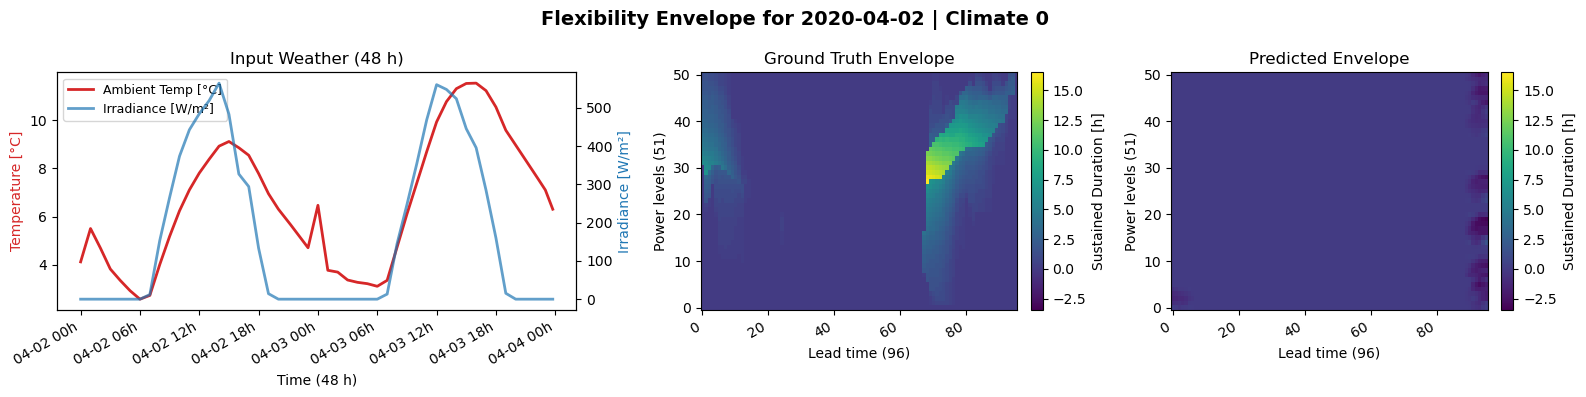

In [53]:
plot_results_for_day(
        model=model,
        building_num=1241,
        climate_id=0,
        year=2020,
        month=4,
        day=2
    )

In [77]:
model.eval()
with torch.no_grad():
    Xb, Yb = next(iter(test_loader)) #get a batch from the test set
    preds = model(Xb.to(DEVICE)) #make predictions


In [78]:
print(Xb.shape)
print(Yb.shape)
print(preds.shape)

torch.Size([16, 4, 192])
torch.Size([16, 1, 51, 96])
torch.Size([16, 1, 51, 96])


In [94]:
print(Yb[3])
#max value of Yb[0]:
print(torch.max(Yb[3]))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(1.5000)


In [96]:
print(preds[0])
print(torch.max(preds[0]))

tensor([[[ 5.7548e-02,  4.6057e-02,  3.3434e-02,  ...,  2.3589e-03,
           4.7766e-03,  6.5026e-03],
         [ 3.6464e-01,  3.6316e-01,  3.5654e-01,  ..., -6.1931e-03,
           1.9465e-03,  8.5367e-03],
         [ 5.5272e-01,  5.7783e-01,  5.9780e-01,  ..., -7.8679e-03,
          -2.8752e-04,  5.9745e-03],
         ...,
         [ 4.6814e+00,  4.6508e+00,  4.6085e+00,  ...,  6.7749e+00,
           7.1638e+00,  7.4610e+00],
         [ 2.6200e+00,  2.5102e+00,  2.3840e+00,  ...,  3.7898e+00,
           4.2431e+00,  4.5875e+00],
         [ 1.5202e+00,  1.3796e+00,  1.1976e+00,  ...,  1.6051e+00,
           1.7482e+00,  1.8744e+00]]])
tensor(27.1681)


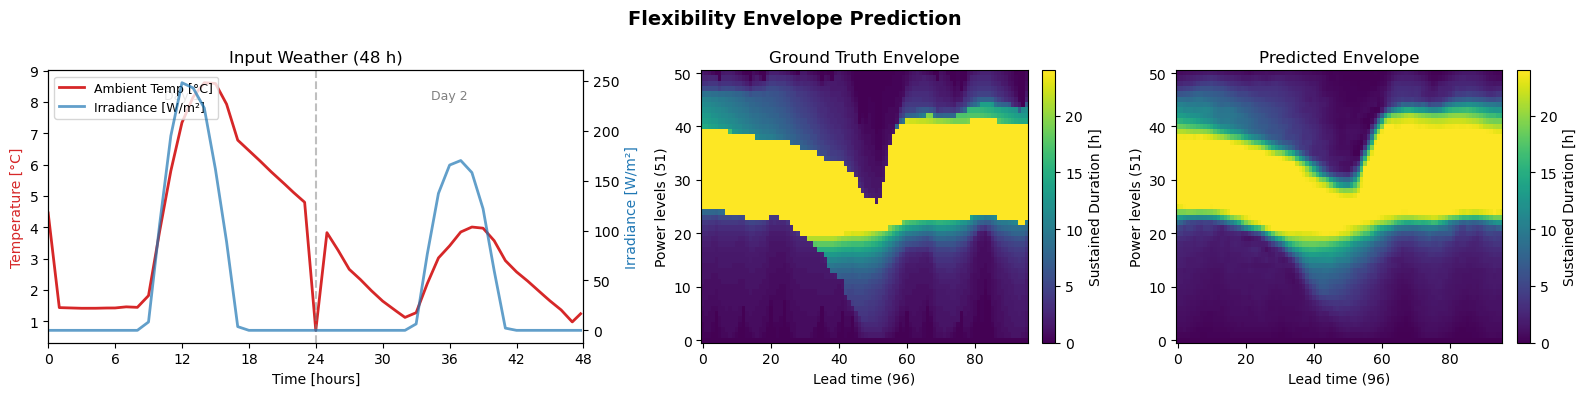

In [79]:

plot_weather_and_envelopes(
            pred=preds[0],
            truth=Yb[0],
            input_features=Xb[0],
            means=means,
            stds=stds,
            title="Flexibility Envelope Prediction"
)


In [ ]:
results_dir = os.path.join(BASE_DIR, "results")
os.makedirs(results_dir, exist_ok=True)
print(f"📁 Saving test predictions to: {results_dir}")

with torch.no_grad():
    sample_idx = 0  # global counter across all batches
    for batch_idx, (X_batch, Y_batch) in enumerate(test_loader):
        preds = model(X_batch.to(DEVICE))  # (B,1,51,96)

        for j in range(X_batch.size(0)):  # loop over batch samples
            X_sample = X_batch[j]
            Y_true = Y_batch[j]
            Y_pred = preds[j].cpu()

            # Generate figure (do not show interactively)
            plt.ioff()  # disable interactive mode for speed
            plot_weather_and_envelopes(
                pred=Y_pred,
                truth=Y_true,
                input_features=X_sample,
                means=means,
                stds=stds,
                title=f"Prediction {sample_idx} — Test Set"
            )

            # Save figure to file
            fname = os.path.join(results_dir, f"prediction{sample_idx}_test_set.png")
            plt.savefig(fname, dpi=200, bbox_inches="tight")
            plt.close()  # free memory

            sample_idx += 1

print(f"✅ Saved {sample_idx} prediction plots to '{results_dir}'")